<a href="https://colab.research.google.com/github/patriciagarcia654/runoff-forecast-project/blob/main/runofffinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving NWM Forecasts Using Deep Learning

## Setup

Install required packages and mount Google Drive to access data.

Run the following to install dependencies:
```bash
!pip install numpy pandas torch scikit-learn matplotlib scipy seaborn
```

Mount Google Drive:
```python
from google.colab import drive
drive.mount('/content/drive')
```

Data is expected in:
- `/content/drive/MyDrive/Colab-Notebooks/StationA` (contains `usgs_A.csv` and `streamflow_*.csv`, e.g., `streamflow_20380357_202106.csv`)
- `/content/drive/MyDrive/Colab-Notebooks/StationB` (contains `usgs_B.csv` and `streamflow_*.csv`)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
from datetime import datetime
import glob
import os

torch.manual_seed(42)
np.random.seed(42)

## Data Preprocessing


In [ ]:
def load_and_preprocess_data(station_folder, usgs_file, nwm_file_pattern):
    usgs_df = pd.read_csv(os.path.join(station_folder, usgs_file))
    usgs_df['USGSFlowValue'] = usgs_df['USGSFlowValue'].clip(lower=0, upper=100)
    usgs_df['USGSFlowValue'] = np.log1p(usgs_df['USGSFlowValue'])  # log(1+x) to handle zeros
    usgs_df['DateTime'] = pd.to_datetime(usgs_df['DateTime'], utc=True).dt.tz_convert(None)

    usgs_df.set_index('DateTime', inplace=True)
    numeric_cols = usgs_df.select_dtypes(include=[np.number]).columns
    usgs_numeric = usgs_df[numeric_cols].resample('h').mean().reset_index()
    usgs_non_numeric = usgs_df[['USGS_GageID']].resample('h').ffill().reset_index()
    usgs_df = usgs_numeric.merge(usgs_non_numeric, on='DateTime', how='inner')

    nwm_files = glob.glob(os.path.join(station_folder, nwm_file_pattern))
    nwm_dfs = []

    nwm_date_format = '%Y-%m-%d_%H:%M:%S'

    for file in nwm_files:
        try:
            df = pd.read_csv(file)
            df['model_initialization_time'] = pd.to_datetime(df['model_initialization_time'], format=nwm_date_format, errors='raise')
            df['model_output_valid_time'] = pd.to_datetime(df['model_output_valid_time'], format=nwm_date_format, errors='raise')
            df['lead_time'] = ((df['model_output_valid_time'] - df['model_initialization_time']).dt.total_seconds() / 3600).astype(int)
            print(f"Unique lead_time values in {file}: {df['lead_time'].unique()}")
            df = df[df['lead_time'].isin(range(1, 19))]
            nwm_dfs.append(df)
        except Exception as e:
            print(f'Error processing {file}: {str(e)}')
            raise

    nwm_df = pd.concat(nwm_dfs, ignore_index=True)
    nwm_df = nwm_df[['model_output_valid_time', 'streamflow_value', 'lead_time', 'streamID']]
    nwm_df.rename(columns={'model_output_valid_time': 'DateTime'}, inplace=True)

    nwm_pivot = nwm_df.pivot_table(
        values='streamflow_value',
        index=['DateTime', 'streamID'],
        columns='lead_time',
        aggfunc='mean'
    ).reset_index()
    nwm_pivot.columns = [str(col) if isinstance(col, (int, float)) else col for col in nwm_pivot.columns]
    print(f"NWM pivot columns: {nwm_pivot.columns}")
    for lead in range(1, 19):
        if str(lead) in nwm_pivot.columns:
            nwm_pivot[str(lead)] = nwm_pivot[str(lead)].clip(lower=0, upper=100)
            nwm_pivot[str(lead)] = np.log1p(nwm_pivot[str(lead)])
        else:
            print(f"Warning: Lead time {lead} not found in NWM data for {station_folder}")

    data = usgs_df.merge(nwm_pivot, on='DateTime', how='inner')
    print(f"Merged data columns: {data.columns}")

    data = data.dropna()

    train_val_end = datetime(2022, 9, 30, 23, 59)
    test_start = datetime(2022, 10, 1, 0, 0)

    train_val = data[data['DateTime'] <= train_val_end].copy()
    test = data[data['DateTime'] >= test_start].copy()
    print(f"Train_val columns: {train_val.columns}")
    print(f"Train/Validation Date Range: {train_val['DateTime'].min()} to {train_val['DateTime'].max()}")
    print(f"Test Date Range: {test['DateTime'].min()} to {test['DateTime'].max()}")

    for lead in range(1, 19):
        train_val[f'residual_{lead}'] = train_val['USGSFlowValue'] - train_val[str(lead)]
        test[f'residual_{lead}'] = test['USGSFlowValue'] - test[str(lead)]

    return train_val, test

## Sequence Creation



In [ ]:
def create_sequences(data, seq_length, features, target):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target].iloc[i+seq_length])
    return np.array(X), np.array(y)

## LSTM Model

The `LSTMModel` class defines a PyTorch LSTM architecture to predict residuals based on historical NWM forecasts and residuals.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## Training Function

The `train_model` function trains the LSTM model, using a train/validation split to monitor performance and save the best model based on validation loss. Includes early stopping and Huber loss to handle outliers.

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, device, epochs=50, batch_size=32, patience=5):
    model = model.to(device)
    criterion = nn.HuberLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)

    best_val_loss = float('inf')
    best_model = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs.squeeze(), y_val_tensor)

        print(f'Epoch {epoch+1}, Validation Loss: {val_loss.item():.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    model.load_state_dict(best_model)
    return model

## Evaluation Metrics



In [ ]:
def calculate_metrics(observed, predicted):
    cc, _ = pearsonr(observed, predicted)
    rmse = np.sqrt(np.mean((observed - predicted)**2))
    pbias = 100 * np.sum(predicted - observed) / np.sum(observed)
    nse = 1 - np.sum((observed - predicted)**2) / np.sum((observed - np.mean(observed))**2)
    return cc, rmse, pbias, nse

## Main Execution



**File paths are set** for Google Drive locations: `/content/drive/MyDrive/Colab-Notebooks/StationA` and `/content/drive/MyDrive/Colab-Notebooks/StationB`. NWM files match the pattern `streamflow_*.csv` (e.g., `streamflow_20380357_202106.csv`).

In [ ]:
seq_length = 24
hidden_size = 64
num_layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
stations = ['/content/drive/MyDrive/Colab-Notebooks/StationA', '/content/drive/MyDrive/Colab-Notebooks/StationB']

all_results = {}

for station in stations:
    station_name = os.path.basename(station)
    print(f'Processing {station_name}...')

    train_val, test = load_and_preprocess_data(
        station_folder=station,
        usgs_file=f'usgs_{station_name[-1]}.csv',
        nwm_file_pattern='streamflow_*.csv'
    )

    results_by_lead = {i: {'obs': [], 'nwm': [], 'corrected': []} for i in range(1, 19)}
    metrics_by_lead = {i: {'cc': [], 'rmse': [], 'pbias': [], 'nse': []} for i in range(1, 19)}
    nwm_metrics_by_lead = {i: {'cc': [], 'rmse': [], 'pbias': [], 'nse': []} for i in range(1, 19)}

    for lead in range(1, 19):
        print(f'Training model for lead time {lead}h...')

        features = [str(lead), f'residual_{lead}']
        train_val_scaled = train_val.copy()
        test_scaled = test.copy()

        X_train, y_train = create_sequences(
            train_val_scaled, seq_length, features, f'residual_{lead}'
        )
        X_test, y_test = create_sequences(
            test_scaled, seq_length, features, f'residual_{lead}'
        )

        train_size = int(0.8 * len(X_train))
        X_val = X_train[train_size:]
        y_val = y_train[train_size:]
        X_train = X_train[:train_size]
        y_train = y_train[:train_size]

        model = LSTMModel(input_size=len(features), hidden_size=hidden_size,
                         num_layers=num_layers)
        model = train_model(model, X_train, y_train, X_val, y_val, device)

        model.eval()
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        with torch.no_grad():
            predictions = model(X_test_tensor).squeeze().cpu().numpy()

        test_runoff_nwm = test_scaled[str(lead)].iloc[seq_length:].values
        test_runoff_obs = test_scaled['USGSFlowValue'].iloc[seq_length:].values
        corrected_forecasts = test_runoff_nwm + predictions
        test_runoff_nwm = np.expm1(test_runoff_nwm)
        test_runoff_obs = np.expm1(test_runoff_obs)
        corrected_forecasts = np.expm1(corrected_forecasts)

        results_by_lead[lead]['obs'] = test_runoff_obs
        results_by_lead[lead]['nwm'] = test_runoff_nwm
        results_by_lead[lead]['corrected'] = corrected_forecasts

        cc, rmse, pbias, nse = calculate_metrics(test_runoff_obs, corrected_forecasts)
        metrics_by_lead[lead]['cc'].append(cc)
        metrics_by_lead[lead]['rmse'].append(rmse)
        metrics_by_lead[lead]['pbias'].append(pbias)
        metrics_by_lead[lead]['nse'].append(nse)

        cc_nwm, rmse_nwm, pbias_nwm, nse_nwm = calculate_metrics(test_runoff_obs, test_runoff_nwm)
        nwm_metrics_by_lead[lead]['cc'].append(cc_nwm)
        nwm_metrics_by_lead[lead]['rmse'].append(rmse_nwm)
        nwm_metrics_by_lead[lead]['pbias'].append(pbias_nwm)
        nwm_metrics_by_lead[lead]['nse'].append(nse_nwm)

    all_results[station_name] = {'results': results_by_lead, 'metrics': metrics_by_lead, 'nwm_metrics': nwm_metrics_by_lead}

Processing StationA...
Unique lead_time values in /content/drive/MyDrive/Colab-Notebooks/StationA/streamflow_20380357_202104.csv: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Unique lead_time values in /content/drive/MyDrive/Colab-Notebooks/StationA/streamflow_20380357_202105.csv: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Unique lead_time values in /content/drive/MyDrive/Colab-Notebooks/StationA/streamflow_20380357_202106.csv: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Unique lead_time values in /content/drive/MyDrive/Colab-Notebooks/StationA/streamflow_20380357_202107.csv: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Unique lead_time values in /content/drive/MyDrive/Colab-Notebooks/StationA/streamflow_20380357_202108.csv: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Unique lead_time values in /content/drive/MyDrive/Colab-Notebooks/StationA/streamflow_20380357_202109.csv: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]

## Visualization



<ipython-input-16-c8777d69155c>:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(runoff_data, patch_artist=True, labels=labels, widths=0.6)


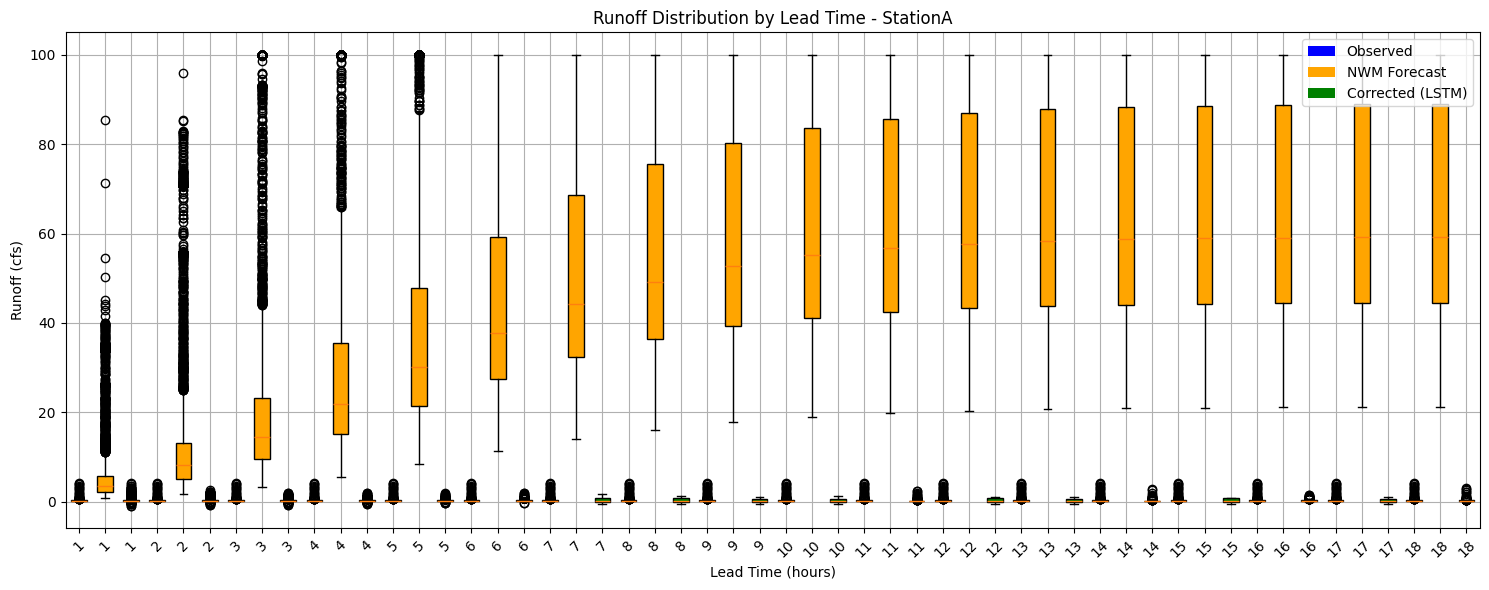

<ipython-input-16-c8777d69155c>:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(metric_data, patch_artist=True, labels=labels, widths=0.6)
<ipython-input-16-c8777d69155c>:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(metric_data, patch_artist=True, labels=labels, widths=0.6)
<ipython-input-16-c8777d69155c>:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(metric_data, patch_artist=True, labels=labels, widths=0.6)
<ipython-input-16-c8777d69155c>:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3

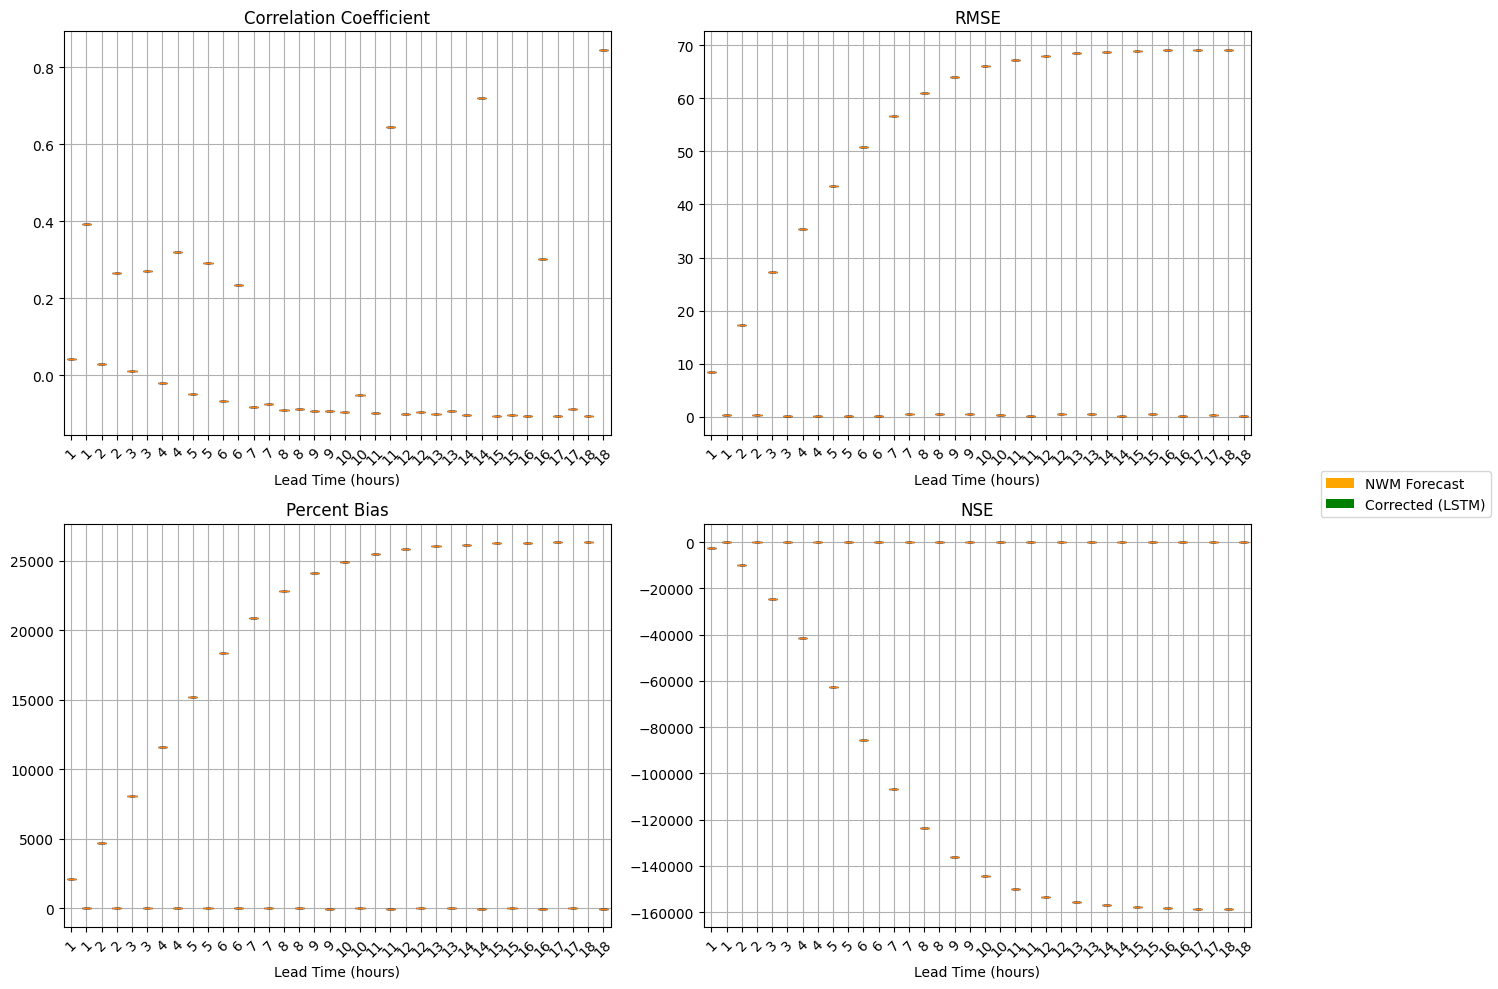

<ipython-input-16-c8777d69155c>:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(runoff_data, patch_artist=True, labels=labels, widths=0.6)


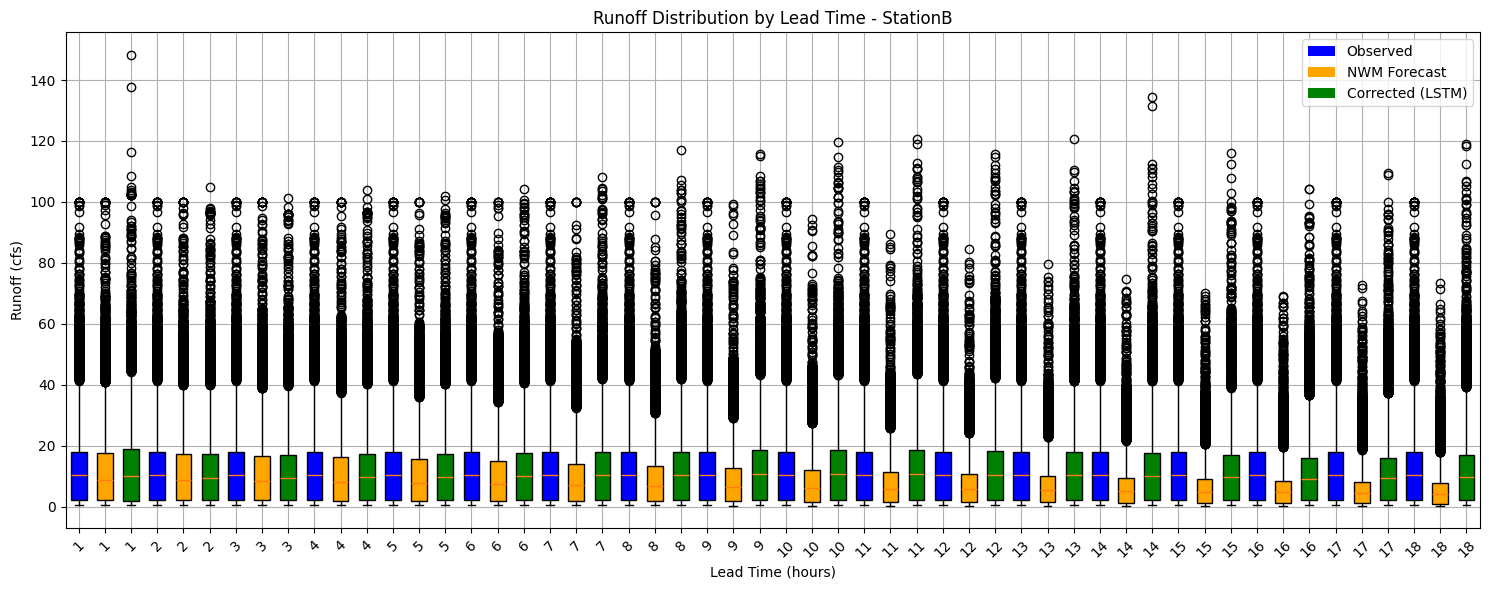

<ipython-input-16-c8777d69155c>:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(metric_data, patch_artist=True, labels=labels, widths=0.6)
<ipython-input-16-c8777d69155c>:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(metric_data, patch_artist=True, labels=labels, widths=0.6)
<ipython-input-16-c8777d69155c>:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(metric_data, patch_artist=True, labels=labels, widths=0.6)
<ipython-input-16-c8777d69155c>:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3

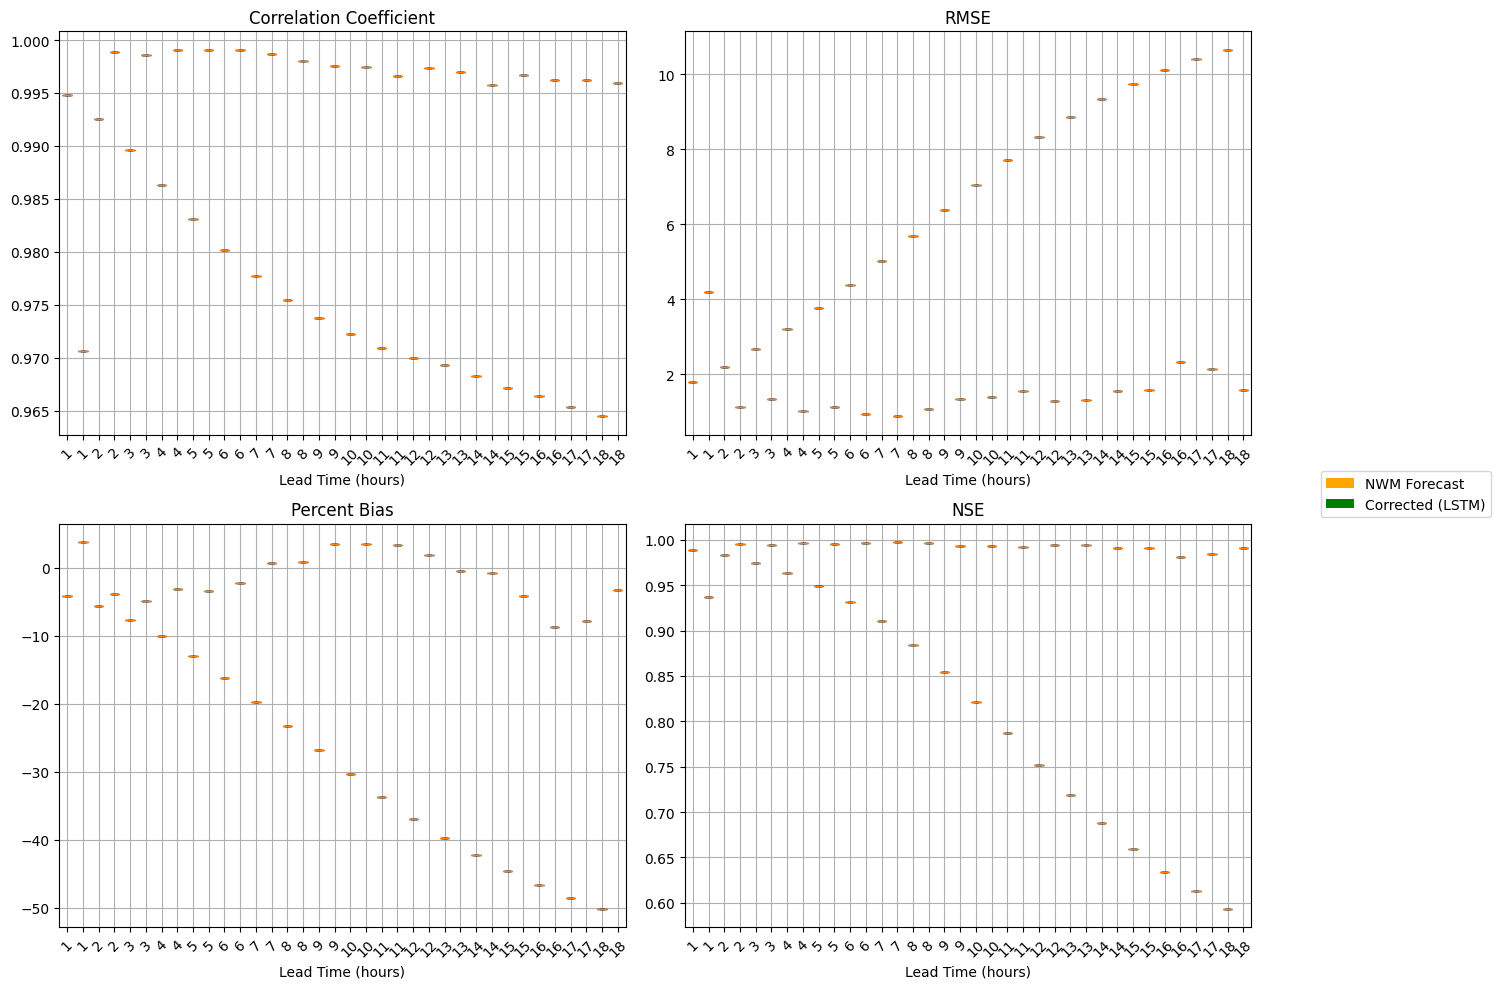

In [ ]:
for station in all_results.keys():
    lead_times = range(1, 19)
    runoff_data = []
    labels = []
    colors = []

    for lead in lead_times:
        obs_data = all_results[station]['results'][lead]['obs']
        nwm_data = all_results[station]['results'][lead]['nwm']
        corrected_data = all_results[station]['results'][lead]['corrected']

        if obs_data.size > 0:
            runoff_data.append(obs_data)
            labels.append(f'{lead}')
            colors.append('blue')
        if nwm_data.size > 0:
            runoff_data.append(nwm_data)
            labels.append(f'{lead}')
            colors.append('orange')
        if corrected_data.size > 0:
            runoff_data.append(corrected_data)
            labels.append(f'{lead}')
            colors.append('green')

    plt.figure(figsize=(15, 6))
    box = plt.boxplot(runoff_data, patch_artist=True, labels=labels, widths=0.6)

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.xlabel('Lead Time (hours)')
    plt.ylabel('Runoff (cfs)')
    plt.title(f'Runoff Distribution by Lead Time - {station}')
    plt.grid(True)
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', label='Observed'),
        Patch(facecolor='orange', label='NWM Forecast'),
        Patch(facecolor='green', label='Corrected (LSTM)')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'runoff_distribution_{station}.png')
    plt.show()
    plt.close()

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    metrics = ['cc', 'rmse', 'pbias', 'nse']
    titles = ['Correlation Coefficient', 'RMSE', 'Percent Bias', 'NSE']

    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i//2, i%2]
        metric_data = []
        labels = []
        colors = []

        for lead in lead_times:
            nwm_metric = all_results[station]['nwm_metrics'][lead][metric]
            if nwm_metric:
                metric_data.append([nwm_metric[0]])
                labels.append(f'{lead}')
                colors.append('orange')
            corrected_metric = all_results[station]['metrics'][lead][metric]
            if corrected_metric:
                metric_data.append([corrected_metric[0]])
                labels.append(f'{lead}')
                colors.append('green')

        box = ax.boxplot(metric_data, patch_artist=True, labels=labels, widths=0.6)

        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        ax.set_title(title)
        ax.set_xlabel('Lead Time (hours)')
        ax.grid(True)
        ax.tick_params(axis='x', rotation=45)

    legend_elements = [
        Patch(facecolor='orange', label='NWM Forecast'),
        Patch(facecolor='green', label='Corrected (LSTM)')
    ]
    fig.legend(handles=legend_elements, loc='center right')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(f'metrics_comparison_{station}.png')
    plt.show()
    plt.close()

## Notes

- **File Paths**: Paths are set for Google Drive: `/content/drive/MyDrive/Colab-Notebooks/StationA` and `/content/drive/MyDrive/Colab-Notebooks/StationB`. NWM files match the pattern `streamflow_*.csv` (e.g., `streamflow_20380357_202106.csv`).
- **USGS Data**: Uses columns 'DateTime' (format: 'YYYY-MM-DD HH:MM:SS+HH:MM'), 'USGSFlowValue', and 'USGS_GageID'. Timestamps are converted to UTC without timezone info for merging.
- **NWM Data**: Uses 'model_initialization_time' and 'model_output_valid_time' in format 'YYYY-MM-DD_HH:MM:SS'.
- **Units**: Assumes USGS and NWM runoff values are in compatible units. Clipping and log transformation are applied to handle outliers, and results are reverse-transformed to original scale (cfs) for plotting.
